In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

C = 299_800_000

In [18]:
def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
        return normalisation_coeffient *np.exp(exponent), normalisation_coeffient
    else:
        return normalisation_coeffient *np.exp(exponent)

In [19]:
array_length = 400 #in pixels
pixel_pitch = 50 #in um
central_freq = 3 #in THz
FWHM_freq = 2 #in THz
theta = 60 #in arcminutes
number_of_averages = 20 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [20]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


57.2604893728845


In [21]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)
#amplitudes = phase *amplitudes
intensity = np.fft.irfft(amplitudes, norm= "forward")

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = C *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_amps = gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber, normalisation_coeffient= normalisation_coeffient)

In [22]:
####### ADD INCOHERANCE ###########

incoherance_sigma = 1.6
number_of_waves = 20 # More waves will create more destructive interferance. The phase will converge but the amplitude will die out.

number_of_freqs = len(freqs)
noise = np.random.normal(0, incoherance_sigma, (number_of_waves, number_of_averages, number_of_freqs))
noise = np.exp(1j*noise)
noise = np.mean(noise, axis= 0)

incoherent_amps = amplitudes *noise # BE CAREFUL WITH THIS! Amplitudes is being broadcasted into a new shape

In [23]:
####### IFFT TO MAKE INTERFEROGRAMS ###########

incoherent_intensity = np.fft.irfft(incoherent_amps, norm= "forward", axis= 1)

In [24]:
####### ADD READ NOISE ########

read_noise_sigma = 0.03

noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_length))
noisy_intensity = incoherent_intensity +noise
noisy_amps = np.fft.rfft(noisy_intensity, norm= "forward", axis= 1)


In [25]:
########## 'TEMPORAL' AVERAGE ############

uncertainty = np.std(noisy_intensity, axis= 0)
averaged_intensity = np.mean(noisy_intensity, axis= 0)

averaged_amps = np.fft.rfft(averaged_intensity, norm= "forward")

In [26]:
########## SHIFT ALL INTERFEROGRAMS AROUND 0 ############

displacement = [n *pixel_pitch*1e-3 for n in range(array_length)]
displacement = np.array(displacement) - (pixel_pitch*1e-3* array_length//2)

intensity = np.fft.fftshift(intensity)
incoherent_intensity = np.fft.fftshift(incoherent_intensity, axes= 1)
noisy_intensity = np.fft.fftshift(noisy_intensity, axes= 1)
averaged_intensity = np.fft.fftshift(averaged_intensity)


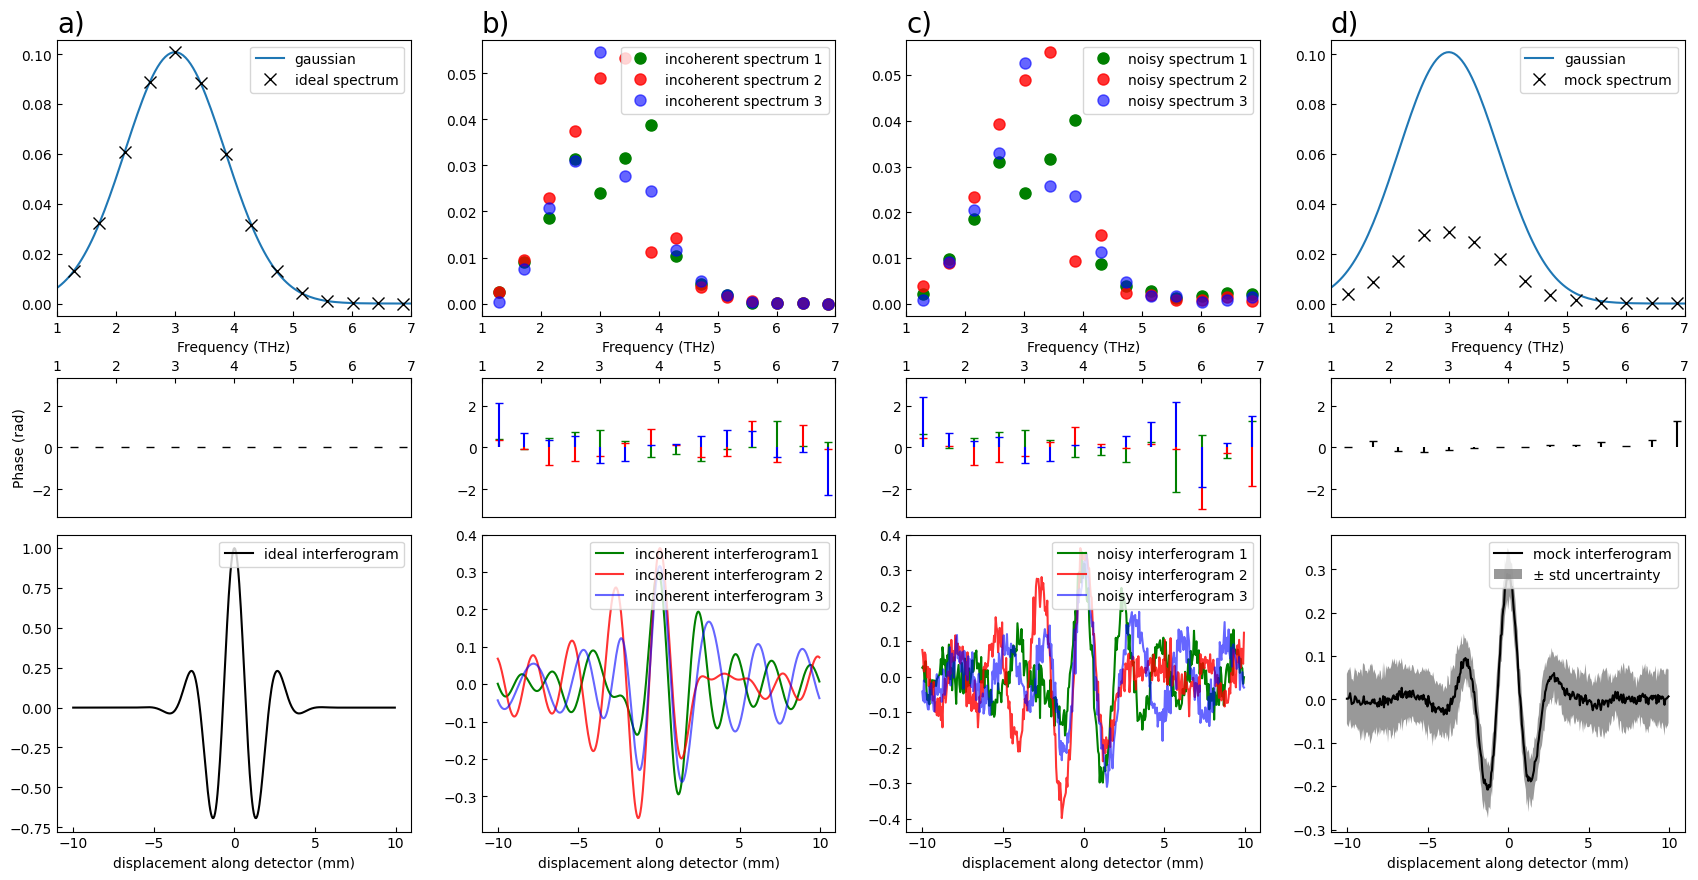

In [27]:
########## MEGACHONKER GRAPH ##############


fig, subaxs1 = plt.subplots(2, 4, figsize= (21,9), height_ratios= (2, 1), gridspec_kw= {"hspace": 0.3, "bottom": 0.35})
fig, subaxs2 = plt.subplots(1, 4, figsize= (21,9), gridspec_kw= {"top": 0.33, "bottom": 0}, num= fig.number)

axs = np.ravel([*subaxs1, subaxs2])

axs[0].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[0].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "ideal spectrum")
axs[0].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs[0].set_title("a)", loc= "left", fontsize= 20)
axs[0].legend(loc ="upper right")

axs[4].stem(freqs, np.angle(amplitudes), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs[4].set(ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[4].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[8].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs[8].set(xlabel= "displacement along detector (mm)")
axs[8].legend(loc ="upper right")

axs[1].plot(freqs, np.abs(incoherent_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "incoherent spectrum 1")
axs[1].plot(freqs, np.abs(incoherent_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "incoherent spectrum 2")
axs[1].plot(freqs, np.abs(incoherent_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "incoherent spectrum 3")
axs[1].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs[1].set_title("b)", loc= "left", fontsize= 20)
axs[1].legend(loc ="upper right")

axs[5].stem(freqs, np.angle(incoherent_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs[5].stem(freqs, np.angle(incoherent_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs[5].stem(freqs, np.angle(incoherent_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs[5].set(xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[5].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[9].plot(displacement, incoherent_intensity[0], color= "green", alpha= 1, label= "incoherent interferogram1")
axs[9].plot(displacement, incoherent_intensity[1], color= "red", alpha= 0.8, label= "incoherent interferogram 2")
axs[9].plot(displacement, incoherent_intensity[2], color= "blue", alpha= 0.6, label= "incoherent interferogram 3")
axs[9].set(xlabel= "displacement along detector (mm)")
axs[9].legend(loc ="upper right")

axs[2].plot(freqs, np.abs(noisy_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "noisy spectrum 1")
axs[2].plot(freqs, np.abs(noisy_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "noisy spectrum 2")
axs[2].plot(freqs, np.abs(noisy_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "noisy spectrum 3")
axs[2].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs[2].set_title("c)", loc= "left", fontsize= 20)
axs[2].legend(loc ="upper right")

axs[6].stem(freqs, np.angle(noisy_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs[6].stem(freqs, np.angle(noisy_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs[6].stem(freqs, np.angle(noisy_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs[6].set(xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[6].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[10].plot(displacement, noisy_intensity[0], color= "green", alpha= 1, label= "noisy interferogram 1")
axs[10].plot(displacement, noisy_intensity[1], color= "red", alpha= 0.8, label= "noisy interferogram 2")
axs[10].plot(displacement, noisy_intensity[2], color= "blue", alpha= 0.6, label= "noisy interferogram 3")
axs[10].set(xlabel= "displacement along detector (mm)")
axs[10].legend(loc ="upper right")

axs[3].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[3].plot(freqs, np.abs(averaged_amps), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "mock spectrum")
axs[3].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs[3].set_title("d)", loc= "left", fontsize= 20)
axs[3].legend(loc ="upper right")

axs[7].stem(freqs, np.angle(averaged_amps), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs[7].set(xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[7].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[11].plot(displacement, averaged_intensity, color= "k", label= "mock interferogram")
axs[11].set(xlabel= "displacement along detector (mm)")
axs[11].fill_between(displacement, averaged_intensity-uncertainty, averaged_intensity+uncertainty, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[11].legend(loc ="upper right")

plt.show()

In [28]:
to_save = np.array([averaged_intensity, uncertainty]).T
#np.savetxt("data\\1dmockanderrors9.csv", to_save, delimiter=",")

### RESOLUTION AND BANDWIDTH

In [29]:
freq_nyquist = C / (4*pixel_pitch*1e-6*np.sin(np.deg2rad(theta/60)))
freq_resolution = C / (2*pixel_pitch*1e-6*array_length*np.sin(np.deg2rad(theta/60)))

freq_nyquist /= 1e12
freq_resolution /= 1e12

print(freq_resolution, freq_nyquist)

0.4294536702966337 85.89073405932673


### LARGE DETECTORS TEST
If the detectors collect light from a large area, how will the spectrum be affected?

In [30]:
from scipy import stats as spstat, interpolate as spinter

bin_size = 1.0 #mm
bins = np.ceil(array_length *pixel_pitch*1e-3 /bin_size)

intensity_binned, bin_edges, bin_number = spstat.binned_statistic(displacement, intensity, statistic= "mean", bins= bins)
print(len(intensity_binned))

bin_size = np.median(np.diff(bin_edges)) #bin_edges should be equally spaced anyway
print("The sensitive area has increased from {0:.2f}um to {1:.2f}um".format(pixel_pitch, bin_size*1e3))
displacement_binned = bin_edges[:-1] +bin_size/2

amplitudes_binned = np.fft.rfft(np.fft.ifftshift(intensity_binned), norm= "forward")
wn_binned = np.fft.rfftfreq(len(intensity_binned), (bin_size *1e-3))
freqs_binned = C* wn_binned /(2*np.sin(np.deg2rad(theta/60))) *1e-12 

############## SUBSAMPLED ############

interpolation = spinter.interp1d(displacement, intensity)
intensity_interpolated = interpolation(displacement_binned)

amplitudes_interpolated = np.fft.rfft(np.fft.ifftshift(intensity_interpolated), norm= "forward")
wn_interpolated = np.fft.rfftfreq(len(intensity_interpolated), (bin_size *1e-3))
freqs_interpolated = C* wn_interpolated /(2*np.sin(np.deg2rad(theta/60))) *1e-12 

20
The sensitive area has increased from 50.00um to 997.50um


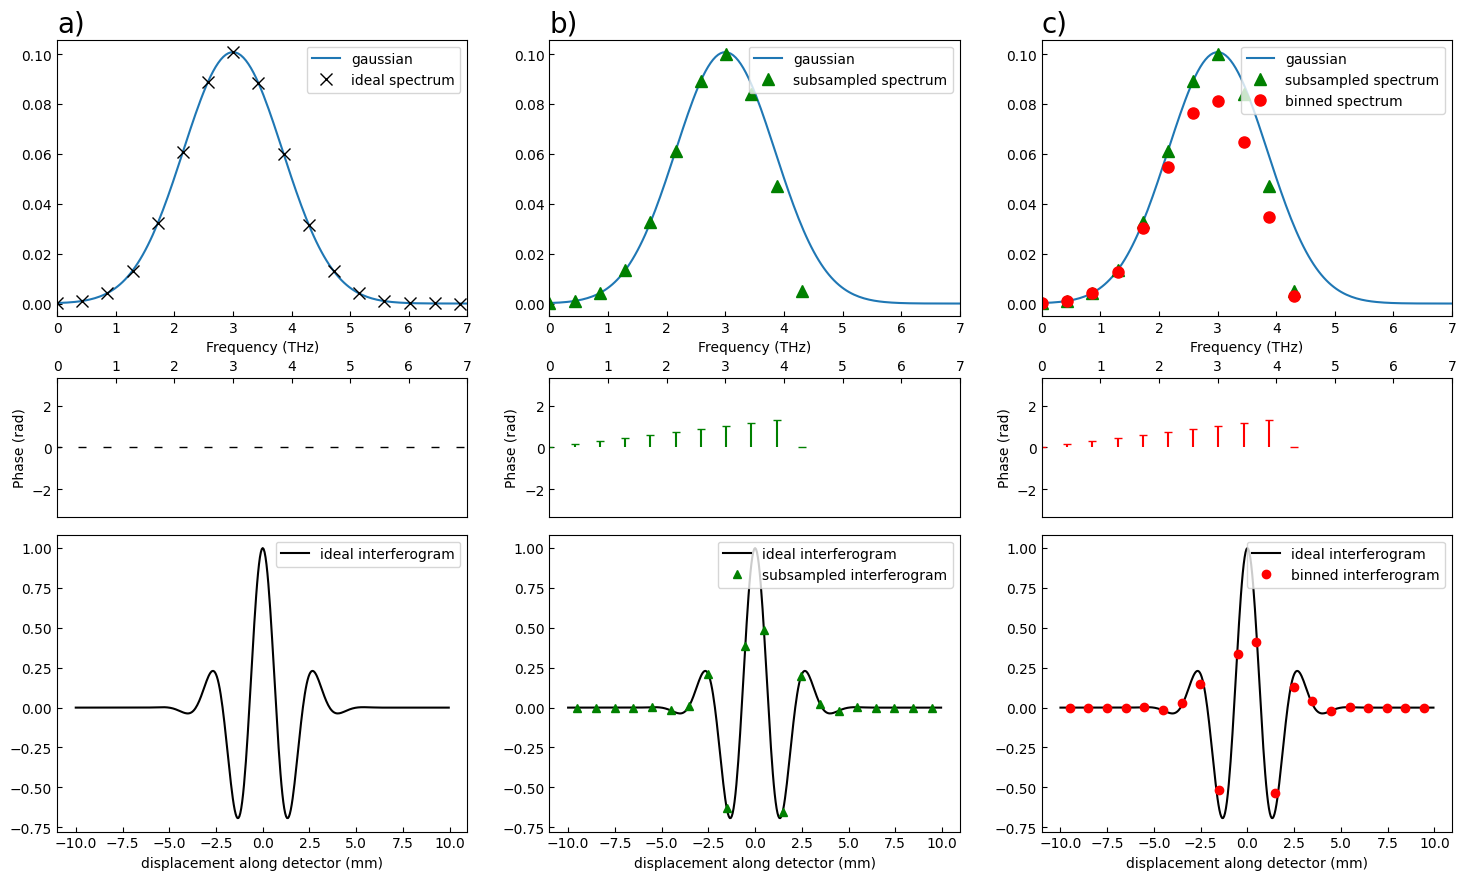

In [31]:
fig, subaxs1 = plt.subplots(2, 3, figsize= (18,9), height_ratios= (2, 1), gridspec_kw= {"hspace": 0.3, "bottom": 0.35})
fig, subaxs2 = plt.subplots(1, 3, figsize= (18,9), gridspec_kw= {"top": 0.33, "bottom": 0}, num= fig.number)

axs = np.ravel([*subaxs1, subaxs2])

axs[0].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[0].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "ideal spectrum")
axs[0].set(xlabel= "Frequency (THz)", xlim= (0, central_freq+2*FWHM_freq))
axs[0].set_title("a)", loc= "left", fontsize= 20)
axs[0].legend(loc ="upper right")

axs[3].stem(freqs, np.angle(amplitudes), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs[3].set(ylabel= "Phase (rad)", xlim= (0, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[3].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[6].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs[6].set(xlabel= "displacement along detector (mm)")
axs[6].legend(loc ="upper right")


axs[1].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[1].plot(freqs_interpolated, np.abs(amplitudes_interpolated), linestyle= "None", marker= "^", markersize= 8, color= "green", label= "subsampled spectrum")
axs[1].set(xlabel= "Frequency (THz)", xlim= (0, central_freq+2*FWHM_freq))
axs[1].set_title("b)", loc= "left", fontsize= 20)
axs[1].legend(loc ="upper right")

axs[4].stem(freqs_interpolated, np.angle(amplitudes_interpolated), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs[4].set(ylabel= "Phase (rad)", xlim= (0, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[4].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[7].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs[7].plot(displacement_binned, intensity_interpolated, color= "green", linestyle= "None", marker= "^", label= "subsampled interferogram")
axs[7].set(xlabel= "displacement along detector (mm)")
axs[7].legend(loc ="upper right")


axs[2].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[2].plot(freqs_interpolated, np.abs(amplitudes_interpolated), linestyle= "None", marker= "^", markersize= 8, color= "green", label= "subsampled spectrum")
axs[2].plot(freqs_binned, np.abs(amplitudes_binned), linestyle= "None", marker= "o", markersize= 8, color= "red", label= "binned spectrum")
axs[2].set(xlabel= "Frequency (THz)", xlim= (0, central_freq+2*FWHM_freq))
axs[2].set_title("c)", loc= "left", fontsize= 20)
axs[2].legend(loc ="upper right")

axs[5].stem(freqs_binned, np.angle(amplitudes_binned), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs[5].set(ylabel= "Phase (rad)", xlim= (0, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))
axs[5].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axs[8].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs[8].plot(displacement_binned, intensity_binned, color= "red", linestyle= "None", marker= "o", label= "binned interferogram")
axs[8].set(xlabel= "displacement along detector (mm)")
axs[8].legend(loc ="upper right")

plt.show()

### EFFECT OF BINNING
Binning not only reduces the number of samples but also convolves the *interferogram* by a boxcar function. The width of the boxcar function is equal to the size of the bin. In the frequency domain, this means that the spectrum is multiplied by the sinc function however, because of the subsampling, only the very first bit of the sinc is observed before it is cut off by the nyquist frequency. Overall this surpresses the higher freqencies. It might be worth deconvolving the interferogram before CS.

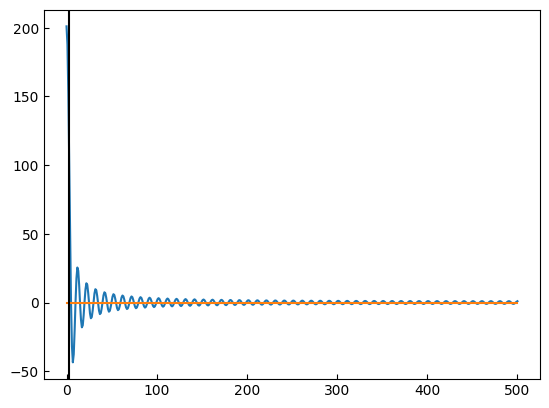

0.7550398502320107


In [32]:
width= 100

x = np.zeros(1001)
x[500 -width:501 +width] = 1.
x = np.fft.ifftshift(x)
FT = np.fft.rfft(x)

fig, ax = plt.subplots()

plt.plot(np.real(FT))
plt.plot(np.imag(FT))
plt.vlines(len(FT)/(2*width+1), ymin= 0, ymax= 1, transform= ax.get_xaxis_transform(), colors= "k")

plt.show()

print(np.real(FT[len(FT)//(2*width+1)] /FT.max()))